In [3]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext

import os
import sys
sys.path.append('../../src')

from config import DatasetConfig
from utils import (
  BaseGeometryTransformer,
  KITTI_GeometricTransformer, UAV_GeometricTransformer,
)

In [5]:
vo = pd.read_csv("../../data/UAV/log0001/px4/09_00_22_vehicle_visual_odometry_0.csv")
# imu = pd.read_csv("data/UAV/log0001/px4/09_00_22_sensor_combined_0.csv")
imu = pd.read_csv("../../data/UAV/log0001/run/mpa/imu0/data.csv")
gps = pd.read_csv("../../data/UAV/log0001/px4/09_00_22_sensor_gps_0.csv")

data_config = DatasetConfig(
        type="kitti",
        mode="stream",
        variant="0033",
        root_path="../../data/KITTI/",
        sensors=[]
    )
geo_transformer = BaseGeometryTransformer()

In [6]:
# imu_w = [
#   'gyro_rad[0]', 'gyro_rad[1]', 'gyro_rad[2]', 
#   ]
# imu_a = [
#   'accelerometer_m_s2[0]', 'accelerometer_m_s2[1]','accelerometer_m_s2[2]'
# ]
imu_w = [
  'GX(rad/s)', 'GY(rad/s)', 'GZ(rad/s)'
]
imu_a = [
  'AX(m/s2)', 'AY(m/s2)', 'AZ(m/s2)'
]
vo_vel_columns = ['velocity[0]', 'velocity[1]', 'velocity[2]']
imu_all_columns = [ 'timestamp',
  'gyro_rad[0]', 'gyro_rad[1]', 'gyro_rad[2]', 
  'accelerometer_m_s2[0]', 'accelerometer_m_s2[1]','accelerometer_m_s2[2]'
  ]
# imu = imu[imu_all_columns]

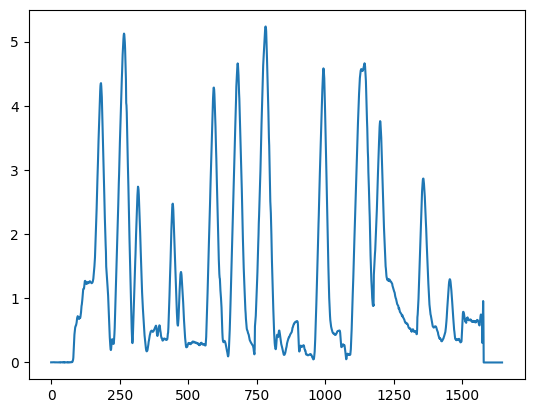

In [7]:
plt.plot(np.arange(len(vo)), np.linalg.norm(vo[vo_vel_columns].values, axis=1))

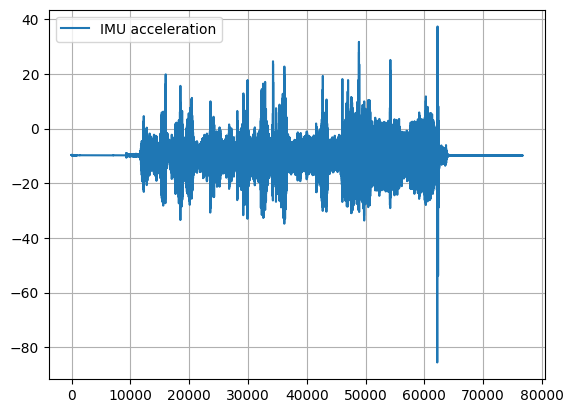

In [8]:
index = np.arange(imu.shape[0])
plt.plot(index, imu[imu_a[2]], label="IMU acceleration")
plt.legend()
plt.grid()

In [9]:
imu[imu_a[2]].mean()

-10.02255223055552

In [10]:
x = np.vstack([
  np.zeros((3, 1)),
  np.zeros((3, 1)),
  np.array([1., 0., 0., 0.]).reshape(-1, 1)
])
delta_t = imu['timestamp(ns)'].diff()
delta_t[0] = 0.0
delta_t /= 1e9
t_last = delta_t[0]

history = []

for i, dt in tqdm(enumerate(delta_t[1:])):
  p, v, q = x[:3], x[3:6], x[6:]
  a, w = imu[imu_a].iloc[i].values, imu[imu_w].iloc[i].values
  a = a.reshape(-1, 1)
  w = w.reshape(-1, 1)
  g = np.array([[0],[0],[-9.81]])
  
  q0, q1, q2, q3 = q[:, 0]
  # R = np.array([
  #     [q0**2 + q1**2 - q2**2 - q3**2, 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
  #     [2*(q1*q2 + q0*q3), q0**2 - q1**2 + q2**2 - q3**2, 2*(q2*q3 - q0*q1)],
  #     [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), q0**2 - q1**2 - q2**2 + q3**2]
  # ])
  R = np.eye(3)
  wx, wy, wz = w[:, 0]
  Omega = np.array([
      [0, -wx, -wy, -wz],
      [wx, 0, wz, -wy],
      [wy, -wz, 0, wx],
      [wz, wy, -wx, 0]
  ])
  norm_w = np.sqrt(np.sum(w**2))

  A = np.cos(norm_w*dt/2) * np.eye(4)
  B = (1/norm_w)*np.sin(norm_w*dt/2) * Omega
  
  p_k = p + v * dt + (R @ a - g)*dt**2 / 2
  v_k = v + (R @ a - g) * dt
  q_k = np.array(A + B) @ q
  q_k /= np.linalg.norm(q_k)
  
  x = np.vstack([
    p_k,
    v_k,
    q_k
  ])
  history.append(x.flatten())
  
history = np.array(history)


76666it [00:57, 1327.47it/s]


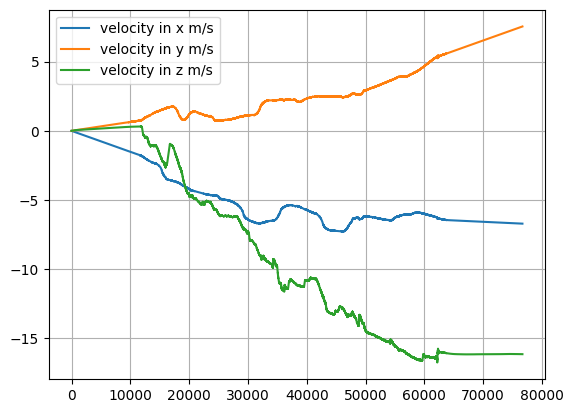

In [11]:
index = np.arange(history.shape[0])
v_hist = history[:, 3:6]
plt.plot(index, v_hist[:, 0], label="velocity in x m/s")
plt.plot(index, v_hist[:, 1], label="velocity in y m/s")
plt.plot(index, v_hist[:, 2], label="velocity in z m/s")
plt.legend()
plt.grid()

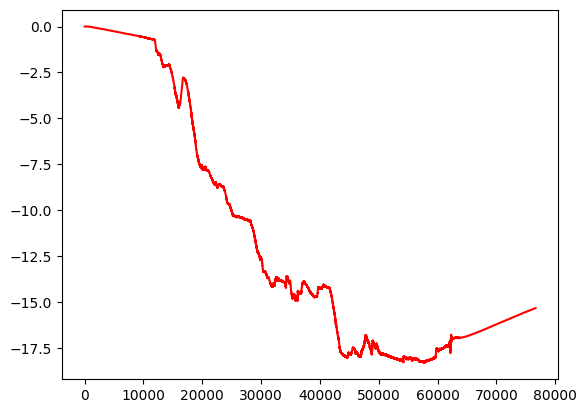

In [12]:
# plt.plot(np.arange(len(vo)), np.sum(vo[vo_vel_columns].values, axis=1), label="PX4 Forward Velocity", color="black")
plt.plot(index, np.sum(v_hist, axis=1), label="Estimated Forward Velocity (m/s)", color="red")

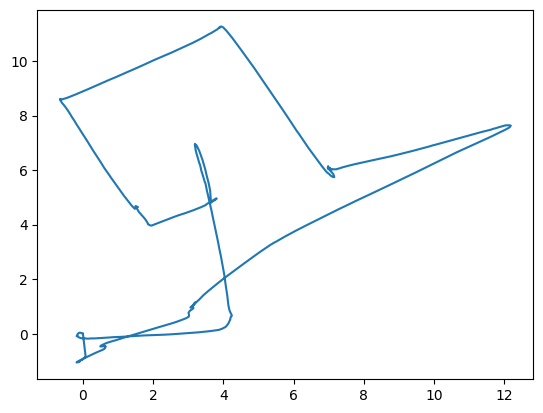

In [13]:
x, y, z = vo[['position[0]', 'position[1]', 'position[2]']].values.T
plt.plot(x, y)

In [32]:
def decimal_place_shift(x: int) -> float:
  return float(x / 10**(len(str(x)) - 2))

lla = gps[['lat', 'lon', 'alt']].copy()
lla['lat'] = lla['lat'].apply(lambda x: decimal_place_shift(x))
lla['lon'] = lla['lon'].apply(lambda x: decimal_place_shift(x))
lla['alt'] = lla['alt'].apply(lambda x: decimal_place_shift(x))

lla.head()

,lat,lon,alt
0,59.394820,24.660131,26.626
1,59.394820,24.660131,26.644
2,59.394820,24.660131,26.657
3,59.394820,24.660131,26.690
4,59.394819,24.660131,26.688


In [33]:
lla = lla[['lon', 'lat', 'alt']].values
print(lla.T.shape)
lla = geo_transformer.lla_to_ned(lla.T, lla[0])

(3, 440)


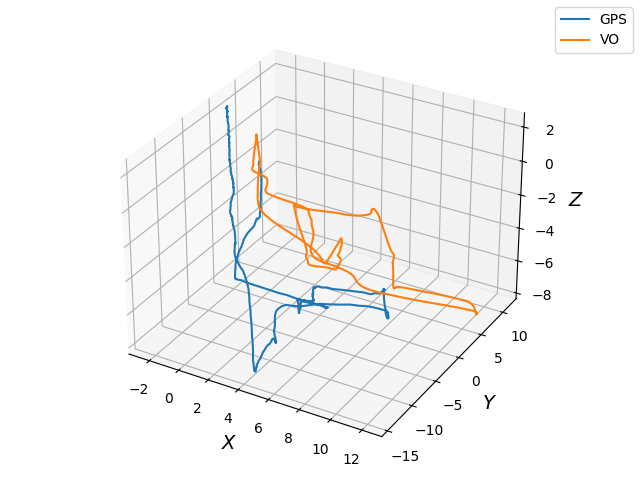

In [30]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = lla
ax.plot(x, y, z, label="GPS")
x, y, z = vo[['position[0]', 'position[1]', 'position[2]']].values.T
ax.plot(x, y, z, label="VO")
ax.set_xlabel('$X$', fontsize=14)
ax.set_ylabel('$Y$', fontsize=14)
ax.set_zlabel('$Z$', fontsize=14)
fig.legend()
fig.tight_layout()



In [196]:
plt.close()